In [1]:
# This code prompts you to upload a file from your computer
from google.colab import files
print('Please upload your kaggle.json file:')
files.upload()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karanrp13","key":"4660db77a1c7fe7d540b601472941c7f"}'}

In [2]:
# Create a directory named .kaggle and move the json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set the correct permissions for the file to prevent a warning
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the dataset using the Kaggle API command
!kaggle datasets download -d tmdb/tmdb-movie-metadata


Dataset URL: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
License(s): other
  0% 0.00/8.89M [00:00<?, ?B/s]
100% 8.89M/8.89M [00:00<00:00, 996MB/s]


In [4]:
# Unzip the downloaded file
!unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


In [5]:
import pandas as pd

# Load the datasets
credits = pd.read_csv('tmdb_5000_credits.csv')
movies = pd.read_csv('tmdb_5000_movies.csv')

# Verify they loaded
print("Successfully loaded the datasets!")
print(f"Movies DataFrame has {movies.shape[0]} rows and {movies.shape[1]} columns.")
print(f"Credits DataFrame has {credits.shape[0]} rows and {credits.shape[1]} columns.")

Successfully loaded the datasets!
Movies DataFrame has 4803 rows and 20 columns.
Credits DataFrame has 4803 rows and 4 columns.


In [7]:
# The 'movies' DataFrame has a 'title' column, but the 'credits' DataFrame does not.
# We need to merge them to link cast/crew to movie details.
# The 'movies' DataFrame has an 'id' column we can rename to 'movie_id' to match the 'credits' DataFrame.
movies = movies.rename(columns={'id': 'movie_id'})
df = pd.merge(credits, movies, on='movie_id')

# We need to drop the extra 'title_y' and rename 'title_x' to 'title'
df = df.drop('title_y', axis=1)
df = df.rename(columns={'title_x': 'title'})

In [8]:
# Display the basic information about our new DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_id              4803 non-null   int64  
 1   title                 4803 non-null   object 
 2   cast                  4803 non-null   object 
 3   crew                  4803 non-null   object 
 4   budget                4803 non-null   int64  
 5   genres                4803 non-null   object 
 6   homepage              1712 non-null   object 
 7   keywords              4803 non-null   object 
 8   original_language     4803 non-null   object 
 9   original_title        4803 non-null   object 
 10  overview              4800 non-null   object 
 11  popularity            4803 non-null   float64
 12  production_companies  4803 non-null   object 
 13  production_countries  4803 non-null   object 
 14  release_date          4802 non-null   object 
 15  revenue              

In [9]:
# Drop columns that are not useful for our prediction model
cols_to_drop = ['homepage', 'overview', 'status', 'tagline', 'original_language', 'original_title']
df = df.drop(cols_to_drop, axis=1)

In [10]:
# Remove the few rows that have missing values for key columns
df = df.dropna(subset=['release_date', 'runtime'])

In [11]:
# Filter out rows where budget or revenue is 0
df = df[(df['budget'] != 0) & (df['revenue'] != 0)]

# Let's check the new size of our DataFrame
print(f"Our cleaned dataset now has {df.shape[0]} rows.")

Our cleaned dataset now has 3229 rows.


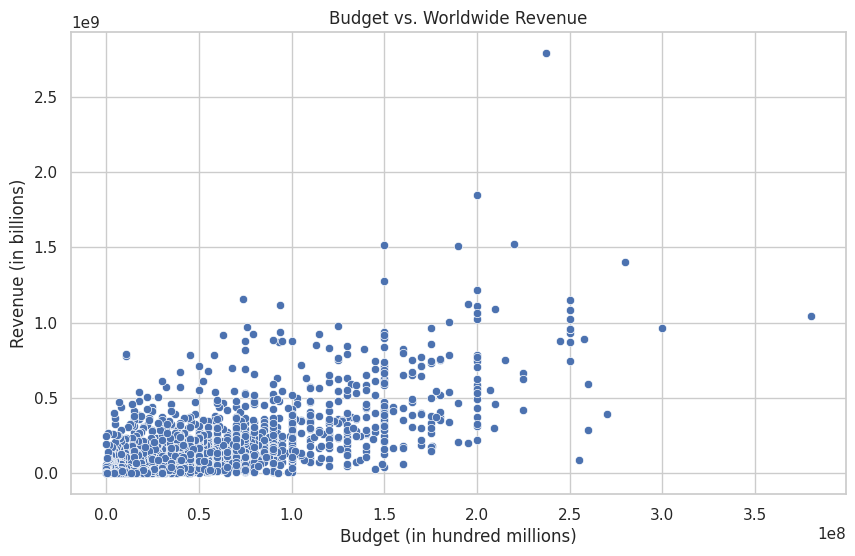

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for our plots
sns.set(style="whitegrid")

# Create a scatter plot of budget vs. revenue
plt.figure(figsize=(10, 6)) # Adjusts the size of the plot
sns.scatterplot(x='budget', y='revenue', data=df)
plt.title('Budget vs. Worldwide Revenue')
plt.xlabel('Budget (in hundred millions)')
plt.ylabel('Revenue (in billions)')
plt.show()

In [13]:
# Create a new 'profit' column
df['profit'] = df['revenue'] - df['budget']

# Use nlargest() to get the top 10 most profitable movies
most_profitable = df.nlargest(10, 'profit')

# Display the titles and their profit
print("Top 10 Most Profitable Movies:")
display(most_profitable[['title', 'profit', 'budget', 'revenue']])

Top 10 Most Profitable Movies:


,title,profit,budget,revenue
0,Avatar,2550965087,237000000,2787965087
25,Titanic,1645034188,200000000,1845034188
28,Jurassic World,1363528810,150000000,1513528810
44,Furious 7,1316249360,190000000,1506249360
16,The Avengers,1299557910,220000000,1519557910
7,Avengers: Age of Ultron,1125403694,280000000,1405403694
124,Frozen,1124219009,150000000,1274219009
546,Minions,1082730962,74000000,1156730962
329,The Lord of the Rings: The Return of the King,1024888979,94000000,1118888979
31,Iron Man 3,1015439994,200000000,1215439994


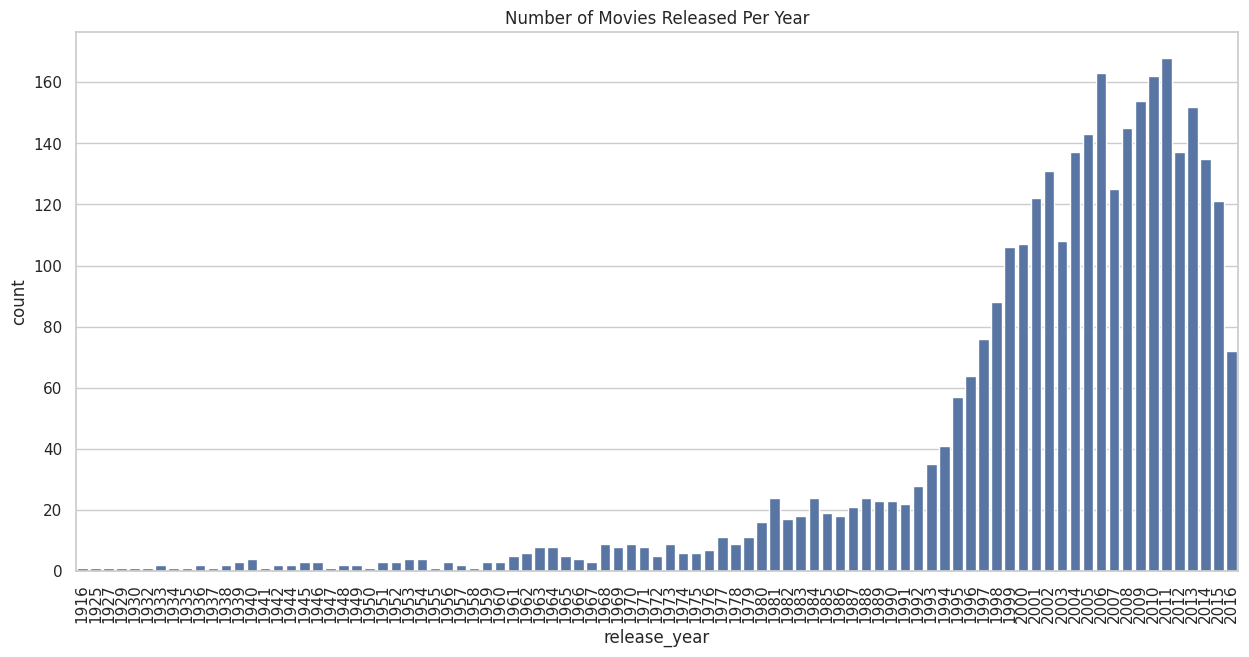

In [14]:
# Convert 'release_date' to a datetime object and extract the year
df['release_year'] = pd.to_datetime(df['release_date']).dt.year

# Create a count plot of movies per year
plt.figure(figsize=(15, 7))
sns.countplot(x='release_year', data=df)
plt.title('Number of Movies Released Per Year')
plt.xticks(rotation=90) # Rotate the x-axis labels to make them readable
plt.show()

In [15]:
import ast

# This function will safely convert the string representation of a list into an actual list
def parse_list(string_list):
    try:
        return ast.literal_eval(string_list)
    except:
        return []

# Apply this function to the 'genres' and 'cast' columns
df['genres'] = df['genres'].apply(parse_list)
df['cast'] = df['cast'].apply(parse_list)

In [16]:
# This function extracts the name of the first genre from the list
def get_main_genre(genre_list):
    if genre_list: # check if the list is not empty
        return genre_list[0]['name']
    return None # Return None if the list is empty

df['main_genre'] = df['genres'].apply(get_main_genre)

In [17]:
# This function extracts the name of the first actor from the cast list
def get_lead_actor(cast_list):
    if cast_list:
        return cast_list[0]['name']
    return None

df['lead_actor'] = df['cast'].apply(get_lead_actor)

In [18]:
# Get the top 15 most frequent lead actors
top_actors = df['lead_actor'].value_counts().nlargest(15).index

# Create a new column, grouping rare actors into 'Other'
df['lead_actor_binned'] = df['lead_actor'].apply(lambda x: x if x in top_actors else 'Other')

# Now, we can create the dummy variables for genre and the binned actors
genre_dummies = pd.get_dummies(df['main_genre'], prefix='genre')
actor_dummies = pd.get_dummies(df['lead_actor_binned'], prefix='actor')

In [19]:
y = df['revenue']


In [20]:
# Select the numerical features we want to use
numerical_features = df[['budget', 'popularity', 'runtime', 'release_year']]

# Concatenate (join) the numerical features with our new dummy variables
X = pd.concat([numerical_features, genre_dummies, actor_dummies], axis=1)

# Let's look at our final feature set
print("Shape of our final feature matrix (X):", X.shape)
X.head()

Shape of our final feature matrix (X): (3229, 39)


,budget,popularity,runtime,release_year,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,genre_Crime,genre_Documentary,...,actor_Harrison Ford,actor_Jim Carrey,actor_Johnny Depp,actor_Matt Damon,actor_Nicolas Cage,actor_Other,actor_Robert De Niro,actor_Sylvester Stallone,actor_Tom Cruise,actor_Tom Hanks
0,237000000,150.437577,162.0,2009,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,300000000,139.082615,169.0,2007,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,245000000,107.376788,148.0,2015,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,250000000,112.312950,165.0,2012,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,260000000,43.926995,132.0,2012,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [21]:
from sklearn.model_selection import train_test_split

# Split our data into training and testing sets (80% train, 20% test)
# random_state=42 ensures that we get the same split every time we run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (2583, 39)
Testing set shape: (646, 39)


In [22]:
from sklearn.ensemble import RandomForestRegressor

# 1. Create an instance of the model
# n_estimators=100 means it will build 100 decision trees
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 2. Train the model using the .fit() method on the TRAINING data
print("Training the model...")
model.fit(X_train, y_train)
print("Model training complete!")

Training the model...
Model training complete!


In [23]:
# Use the .predict() method on the test data
predictions = model.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: ${mae:,.2f}")

Mean Absolute Error: $65,261,753.25


In [25]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R-squared (R²): {r2:.2f}")

R-squared (R²): 0.65


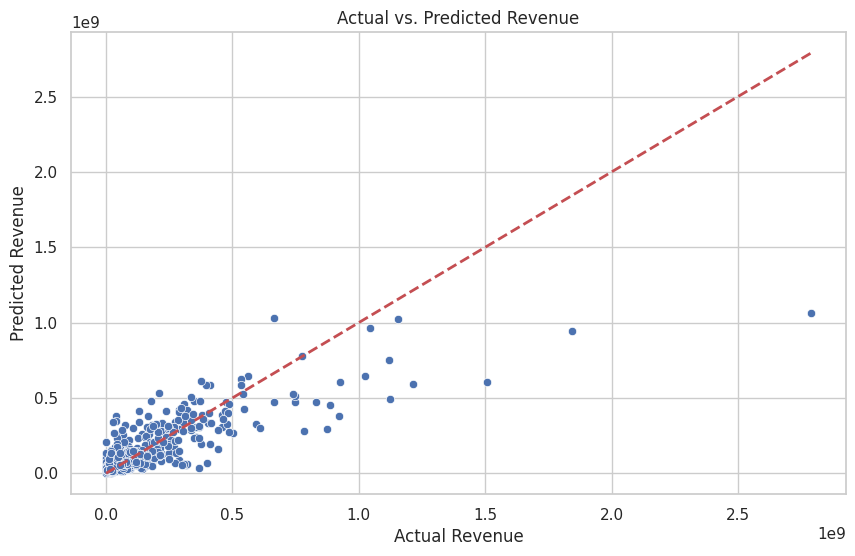

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Revenue")

# Add a line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

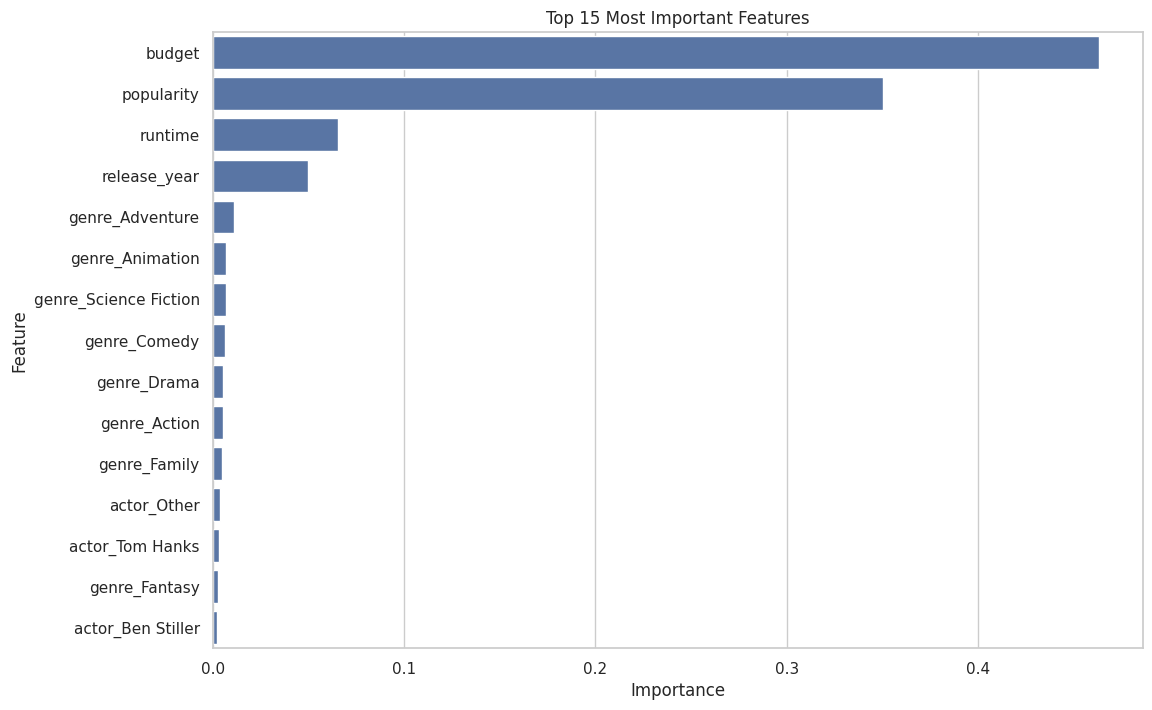

In [27]:
# Create a series of feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.head(15), y=feature_importances.head(15).index)
plt.title("Top 15 Most Important Features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [32]:
import joblib

# Let's use the tuned Random Forest model from the last step
final_model = model

# Save the model to a file named 'movie_revenue_predictor.pkl'
joblib.dump(final_model, 'movie_revenue_predictor.pkl')

print("Model saved successfully!")

# You can also load it back to make sure it works
loaded_model = joblib.load('movie_revenue_predictor.pkl')
print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


In [33]:
!pip install gradio

In [34]:
import gradio as gr
import pandas as pd

# The list of all columns the model was trained on (get this from your final X_train)
MODEL_COLUMNS = X_train.columns

def predict_revenue(budget, popularity, runtime, release_year, main_genre, lead_actor, director):
    # 1. Create a dictionary from the inputs
    input_data = {
        'budget': budget,
        'popularity': popularity,
        'runtime': runtime,
        'release_year': release_year,
        'genre_' + main_genre: 1,
        'actor_' + lead_actor: 1,
        'director_' + director: 1
    }

    # 2. Convert to a pandas DataFrame
    input_df = pd.DataFrame([input_data])

    # 3. Align columns with the model's training data
    # This is the most critical step! It ensures our single row of data
    # has the exact same columns as the data the model was trained on.
    # Any missing columns (e.g., other genres/actors) will be filled with 0.
    model_input = input_df.reindex(columns=MODEL_COLUMNS, fill_value=0)

    # 4. Make a prediction
    prediction = loaded_model.predict(model_input)

    # 5. Format the output as a currency string
    return f"Predicted Worldwide Revenue: ${prediction[0]:,.0f}"

In [35]:
# Create lists for the dropdown menus from our original dataframe
# This makes the UI much more user-friendly
genre_choices = sorted(df['main_genre'].dropna().unique())
actor_choices = sorted(df['lead_actor_binned'].dropna().unique())
director_choices = sorted(df['director_binned'].dropna().unique())


# Define the input components for the Gradio interface
inputs = [
    gr.Number(label="Budget (in USD)"),
    gr.Number(label="Popularity Score"),
    gr.Number(label="Runtime (in minutes)"),
    gr.Slider(minimum=1980, maximum=2025, step=1, label="Release Year"),
    gr.Dropdown(choices=genre_choices, label="Main Genre"),
    gr.Dropdown(choices=actor_choices, label="Lead Actor"),
    gr.Dropdown(choices=director_choices, label="Director")
]

# Define the output component
output = gr.Textbox(label="Prediction")

# Create and launch the interface
app = gr.Interface(
    fn=predict_revenue,
    inputs=inputs,
    outputs=output,
    title="🎬 Movie Revenue Predictor",
    description="Enter the details of a movie to predict its worldwide box office revenue. This app uses a trained Random Forest model."
)

# Launch the app! share=True gives you a public link to share.
app.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a187b1727c0ec235b5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
